In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [2]:
import emcee

## Writing my own MCMC

Learning from: https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

Also Josh Speagle

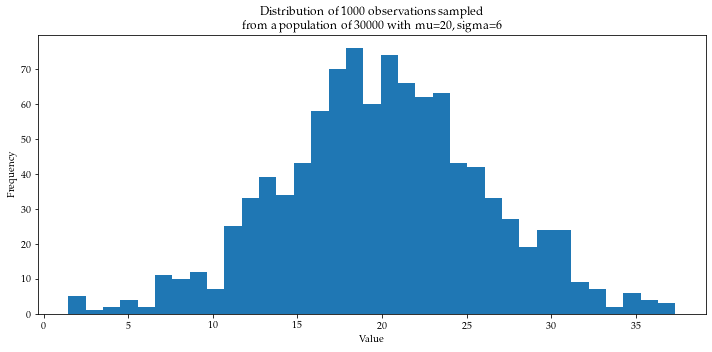

20.039846856446797

In [3]:
#Form a population of 30,000 individual, with average=10 and scale=3
N = 30000
n = 1000
mu = 20
sig = 6
population = np.random.normal(mu,sig,N)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, N, n)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title(f"Distribution of {n} observations sampled \n from a population of {N} with mu={mu}, sigma={sig}")
plt.show()
mu_obs = observation.mean()
mu_obs

In [4]:
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

In [5]:
#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))

In [6]:
def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    total_list = []
    for i in tqdm(range(iterations)):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
            total_list.append([i, x_new[0], "blue", x_new[1]])
        else:
            rejected.append(x_new)
            total_list.append([i, x_new[0], "red", x_new[1]])

    return np.array(accepted, dtype = float), np.array(rejected, dtype = float), np.array(total_list, dtype = object)

In [7]:
init_sigma = 1.1
accepted, rejected, total = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu,init_sigma], 500,observation,acceptance)

100%|██████████| 500/500 [00:00<00:00, 8998.76it/s]


In [8]:
iterations = np.array(total.T[0], dtype = int)
values_mean = np.array(total.T[1], dtype = float)
values_sigma = np.array(total.T[3], dtype = float)
colors = np.array(total.T[2], dtype = str)

In [9]:
# plt.hist(values_sigma, bins = 50)

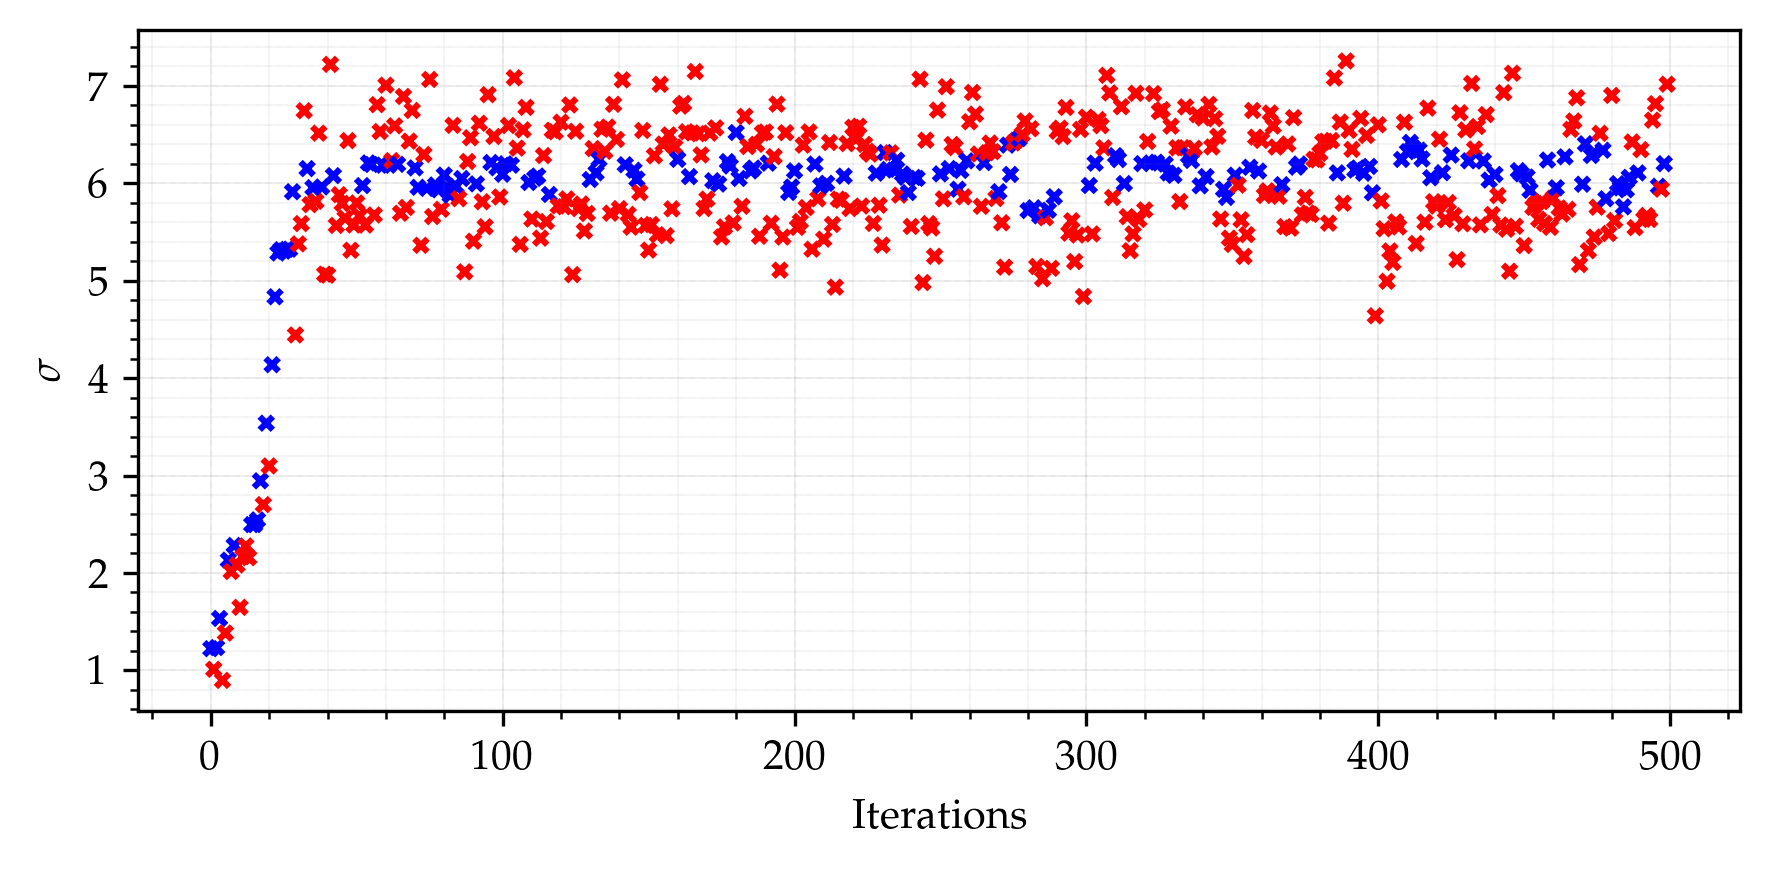

In [10]:
plt.figure(dpi = 300, figsize = (6,3))
plt.scatter(iterations, values_sigma, color = colors, marker = "x", s = 10)
plt.xlabel("Iterations")
plt.ylabel(r"$\sigma$")
utkarshGrid()
plt.show()

## Now try do the same thing in emcee

In [27]:
import scipy 
import math 


def manual_log_like_normal2(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    resid = data-x[0]
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-(resid**2) / (2*x[1]**2))

def logpost(data, sig, mu): 
    theta = (mu, sig)
    logp = prior(theta)
    logl = manual_log_like_normal2((theta), x)
#     logl = log_likelihood(theta, data)
    return (logl + logp)  # posterior

In [31]:
import emcee

ndim = 2  # number of parameters
nwalkers = 100  # number of "walkers" or "chains" to run

# initialize starting positions from our initial approximation
p0 = np.random.rand(nwalkers, ndim)

# initialize our sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args = [sig, mu])

# # initial "burn-in" run
# state = sampler.run_mcmc(p0, 50, progress=True)
# sampler.reset()

# final "production" run
state = sampler.run_mcmc(p0, 1000, progress=True)

# get final chains
samples = sampler.get_chain()

100%|██████████| 1000/1000 [00:02<00:00, 382.83it/s]


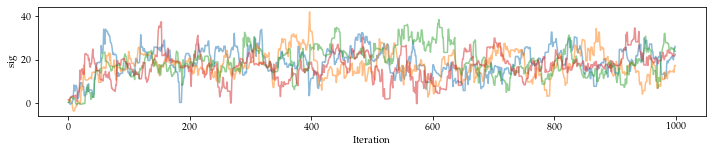

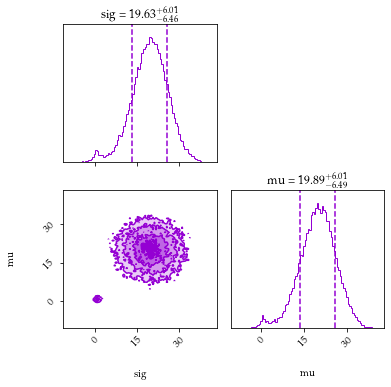

In [32]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
[plt.plot(samples[:, i, 0], alpha=0.5) for i in range(4)]
plt.xlabel('Iteration')
plt.ylabel('sig')
plt.show()

# plot posterior
import corner
corner.corner(samples.reshape(-1, ndim),  # collect samples into N x 1 array
              bins=100,  # bins for histogram
              show_titles=True, quantiles=[0.16, 0.84],  # show median and uncertainties
              labels=['sig', "mu"],
              color='darkviolet', truth_color='black',  # add some colors
              **{'plot_datapoints': False, 'fill_contours': True});  # change some default options